# VaR&StressTesting Workbook
--- Dec-03-2019, Alan, Shaolun.du@gmail.com

This is a detailed workbook with examples on VaR calculation and StressTesting calculations for swaps. We will start from rate curve building to swap pricing to VaR and StressTesting. In the following, I will seperate this workbook into tow parts: 
<h4 align="center">VaR</h4>
<h4 align="center">StressTesting</h4>

<span style="color:blue">
- VaR: Value at risk (VaR) is a measure of the risk of loss for investments. It estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set time period such as a day. VaR is typically used by firms and regulators in the financial industry to gauge the amount of assets needed to cover possible losses. There are three different ways to calculate VaR: 
    - Historical method: The historical method simply re-organizes actual historical returns, putting them in order from worst to best. It then assumes that history will repeat itself, from a risk perspective.
    - Variance-Covariance method: This method assumes that returns are normally distributed. In other words, it requires that we estimate only two factors - an expected (or average) return and a standard deviation - which allow us to plot a normal distribution curve.
    - ***Monte-Carlo simulation***: The third method involves developing a model for future stock price returns and running multiple hypothetical trials through the model. A Monte Carlo simulation refers to any method that randomly generates trials, but by itself does not tell us anything about the underlying methodology.
    
I will talk about how to use Monte-Carlo method and this knowledge is heavily depended on my previous post. PLEASE refer to ShortRate model and XVAcalculation workbooks.

- StressTesting: Stress testing is a form of deliberately intense or thorough testing used to determine the stability of a given system or entity. It involves testing beyond normal operational capacity, often to a breaking point, in order to observe the results. In financial area, people tend to test a given portfolio (strategy) under market stressed times. Later on, I will talk about how to identify market stressed periods as well as how to define a set of stressed conditions (scenarios) for stress testing. Basically, what we will do is to re-value a portfolio/strategy given those different market scenarios.
    - In this method, I will directly refer to my paper on market review. Please take a look on "MarketStressedPeriodReview_LongPeriod.pdf". 
</span>

### Before getting into codes, Please include all these libraries:

In [1]:
import math
import numpy as np
import QuantLib as ql
import datetime as dt
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats 
import seaborn as sns
%matplotlib inline

## VaR calculation on Swap

Now, let us start to work on VaR calculation on a given swap. I will again use the previous USD swap as an example here.

## Covariance method with PV01

Given a set of market quotes:(The same swap I will use with Monte-Carlo method later)

Swap Coupon = 1.62%

Swap Maturity = 7 Years

Swap PV01 = 660 per 1MM Notional

Alpha = 1% implied z-score = 2.33

Historical changes in 7 Years US swap rate std. = 0.02

Apply VaR formula as following:
$$VaR = PV01(\%)*CloseRate*std(rate change)*ZFactor*100 $$

So we have: 
$$VaR_{0.01,1D} = 0.066*0.0162*0.02*2.33*100 = 0.498\%%$$

Convert into 14D USD value approximated 18633.

## Monte-Carlo Simulation method:


We will following the procedure:
<span>
<font color='blue'>

1. Get zero coupon rates from the swap rates series by bootstrap.
2. Deduce value at risk scenarios from this serie (evaluation of zero rates at each time step), if what we want is a 10d VaR, you can consider 10d variations.
3. For each VaR scenario, apply the scenario to today's zero curve, and value the swap using the resulting zero curve. This will give us a vector of NPVs and hence a vector of P&Ls (wrt today's NPV).
4. Get the relevant quantile of this P&L vector, this is your value at risk.
</span>

## Step 0 - Define current zero curve and a test swap to run VaR:

In [2]:
# Helper function for curve building please refer to previous post
# Pull out a yield curve for pricing
# Details please refer to previous workbook, we will use USD LIBOR curve here.
Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.UnitedStates(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "Future":{ "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "ConVes_Adj":ql.QuoteHandle(ql.SimpleQuote(0.0)),# For convexity adjustment
               "Calendar":ql.UnitedStates(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.USDLibor(ql.Period(3,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(3,ql.Months),
              "FloatingLegFrequency":ql.Quarterly,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Semiannual,
              "FixedLegTenor":ql.Period(6,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.UnitedStates(),
            },
}
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
    }
def Bootstrapping( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    futures  = Market["Future"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    futuresc_con  = Convention["Future"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    futuresHelpers = [ ql.FuturesRateHelper( ql.QuoteHandle(futures[d]),
                                             d, futuresc_con["LengthInMonths"],
                                             futuresc_con["Calendar"], futuresc_con["BsDay"],
                                             futuresc_con["EOM"], futuresc_con["DayCount"],
                                             futuresc_con["ConVes_Adj"])
                       for d in futures.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    yts.enableExtrapolation()
    return yts
# Generate USE LIBOR yield curve with TermStructure object
base_yts = Bootstrapping(Mkt_dict, Con_dict)
hyts = ql.RelinkableYieldTermStructureHandle(base_yts) # Build discounting curve into a term structure

<h4>Swap Object Build: ATM swap with 1MM notional and DV01 = 659.</h4>

In [3]:
# Swap object defined as a dictionary with float leg and fixed leg
# Inorder to advance date in Quantlib we have to use a calender object
t_calendar = ql.UnitedStates()
settle_date = ql.Date(1, 12, 2019)
maturity_date = ql.Date(1, 12, 2026)
LiborXm = ql.USDLibor(ql.Period(3, ql.Months),hyts)
V_Swap_Dict = {
    "Type":ql.VanillaSwap.Payer,
    "Notional":1000000,
    "Fixed_Leg":{
        "fixedSchedule":ql.Schedule( settle_date, 
                                     maturity_date, 
                                     ql.Period(6, ql.Months), ql.UnitedStates(),
                                     ql.ModifiedFollowing, ql.ModifiedFollowing,
                                     ql.DateGeneration.Forward, False),
        "fixedRate":0.0162, # Approx. ATM swap
        "fixedDayCount":ql.Thirty360(),
    },
    "Float_Leg":{
        "floatSchedule": ql.Schedule( settle_date, 
                                      maturity_date, 
                                      ql.Period(3, ql.Months), ql.UnitedStates(),
                                      ql.ModifiedFollowing, ql.ModifiedFollowing,
                                      ql.DateGeneration.Forward, False),
        "index":LiborXm,
        "spread":0,
        "floatingDayCount":ql.Actual360(),
    },
}
swap_test = ql.VanillaSwap(  V_Swap_Dict["Type"], 
                             V_Swap_Dict["Notional"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedSchedule"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedRate"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedDayCount"], 
                             V_Swap_Dict["Float_Leg"]["floatSchedule"],
                             V_Swap_Dict["Float_Leg"]["index"],
                             V_Swap_Dict["Float_Leg"]["spread"], 
                             V_Swap_Dict["Float_Leg"]["floatingDayCount"] )
swap_engine = ql.DiscountingSwapEngine(hyts)
swap_test.setPricingEngine(swap_engine)
hyts.linkTo(base_yts)
ql.Settings.instance().evaluationDate = Mkt_dict["SDate"]
print("Current Date={:},NPV={:}".format(Mkt_dict["SDate"],swap_test.NPV()))
DV01 = abs(swap_test.fixedLegBPS())
print('DV01={}'.format(DV01))

Current Date=November 18th, 2019,NPV=-16.738972403371008
DV01=659.1436890765253


## Step 1 - Define Monte-Carlo simulation with rates risk scenarios:

In [4]:
# Hull-White factor calibrated from short-rate model, see previous post
startDate = ql.Date(18, 11, 2019)
ql.Settings.instance().evaluationDate = startDate
a = 0.01647
sigma = 0.00712
volas = [ql.QuoteHandle(ql.SimpleQuote(sigma)),
         ql.QuoteHandle(ql.SimpleQuote(sigma))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(a))]
model = ql.Gsr(hyts, [startDate+100], volas, meanRev )
process = model.stateProcess()
# Define evaluation grid
date_grid = [startDate + ql.Period(i,ql.Days) for i in range(0,30*12*5)]
date_grid += [LiborXm.fixingDate(x) for x in V_Swap_Dict["Float_Leg"]["floatSchedule"]]
date_grid = np.sort(np.unique(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(startDate, x))(date_grid)
delta = time_grid[1:] - time_grid[:-1]
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

# Generate N paths
N = 2000
x = np.zeros((N, len(time_grid))) # Zero Rates paths
y = np.zeros((N, len(time_grid)))
pillars = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
zero_bonds = np.zeros((N, len(time_grid), len(pillars)))
for j in range(12):
    zero_bonds[:, 0, j] = model.zerobond(pillars[j], 0, 0)
for n in range(0,N):
    dWs = generator.nextSequence().value()
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        x[n,i] = process.expectation( t0, x[n,i-1], delta[i-1]) \
                + dWs[i-1] * process.stdDeviation( t0, x[n,i-1], delta[i-1])
        y[n,i] = (x[n,i] - process.expectation(0,0,t1)) / process.stdDeviation(0,0,t1)
        for j in range(12):
            zero_bonds[n, i, j] = model.zerobond(t1+pillars[j], t1, y[n, i])

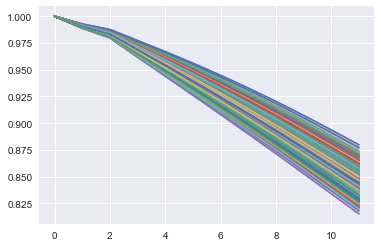

In [5]:
# Quick for scenario curves in 10Days
for i in range(0,N):
    plt.plot(zero_bonds[i,10, :])

### NOTE: The key point and difference between VaR and CVA calculation is:

- VaR value different curves as if they are todays zerocurves
- CVA value different curves as if they are future zerocurves

## Step 2 - VaR calculation: Counting on swap value matrix with simulated path.

After simulating all possible scenarios, we would like to take a given time period and running on the npv matrix to get a potnetial distribution at given time node.

### Let us assume the following:

- VaR alpha = 1%
- T = 14 Days

#### Run the VaR function with T = 14 and alpha = 1% also get distribbution

In [6]:
#Swap pricing under each scenario
vaR_T = 14
val_mat = np.zeros(N)
for p in range(0,N):
    ql.IndexManager.instance().clearHistories()
    # Starting date always set to be todays date
    date = date_grid[0]
    ycDates =  [ date, date + ql.Period(6, ql.Months) ] 
    ycDates += [ date + ql.Period(i,ql.Years) for i in range(1,11) ]
    yc = ql.DiscountCurve( ycDates, 
                           zero_bonds[p, vaR_T, :], 
                           ql.Actual365Fixed() )
    yc.enableExtrapolation()
    hyts.linkTo(yc)
    if LiborXm.isValidFixingDate(date):
        fixing = LiborXm.fixing(date)
        LiborXm.addFixing(date, fixing)
    val_mat[p] = swap_test.NPV()

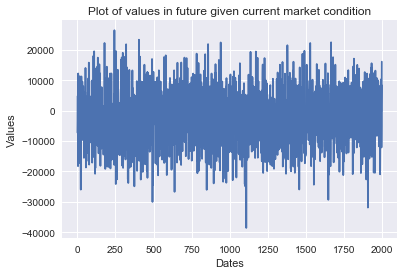

In [7]:
alpha = 0.01
VaR = sorted(val_mat)[int(alpha*N)]
plt.plot(val_mat)
plt.title('Plot of values in future given current market condition')
plt.xlabel('Dates')
plt.ylabel('Values')

VaR for this swap at T = 14 is -22638.45934365211


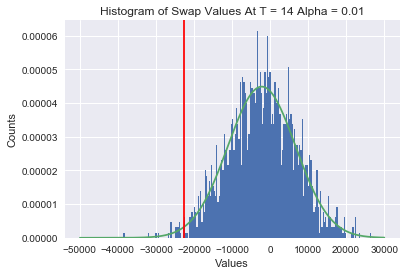

In [8]:
# Using seaborn plot a histogram for swap values
plt.hist( val_mat,bins= int(len(val_mat)/10), normed=True )
m, s = stats.norm.fit(val_mat)
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(val_mat))
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label="Norm")
plt.axvline(x=VaR,color="red")
plt.title('Histogram of Swap Values At T = {:} Alpha = {:}'.format(vaR_T,alpha))
plt.xlabel('Values')
plt.ylabel('Counts')
print("VaR for this swap at T = {:} is {:}".format(vaR_T,VaR))

## StressTesting on Swap

Now let us take a look on stresstesting calculation on a given swap. We will continue to use the previous USD swap.

Basically, stresstesting starts with stress condition(secnario) defination. In this notebook, I will  follow the stressed scenario I did in my paper "MarketStressedPeriod_review.pdf". Please refer to that for information. In the following, I will list out different scenarios as given:

1. Curve Steepening: Linear upward shocking from Y2 to Y30.
2. Curve Flatterning: Linear downward shocking from Y2 to Y30.
3. Curve Convex Up: Linear upward shocking from Y2 to Y15 and downward shocking from Y15 to Y30.
4. Curve Convex Down: Linear downward shocking from Y2 to Y15 and upward shocking from Y15 to Y30.

Now, let us start shock curves for each scenario and re-price the swap.

In [41]:
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
    }
# Generate USE LIBOR yield curve with TermStructure object
base_yts = Bootstrapping(Mkt_dict, Con_dict)
hyts = ql.RelinkableYieldTermStructureHandle(base_yts) # Build discounting curve into a term structure

In [42]:
# Swap object defined as a dictionary with float leg and fixed leg
# Inorder to advance date in Quantlib we have to use a calender object
t_calendar = ql.UnitedStates()
settle_date = ql.Date(1, 12, 2019)
maturity_date = ql.Date(1, 12, 2026)
LiborXm = ql.USDLibor(ql.Period(3, ql.Months),hyts)
V_Swap_Dict = {
    "Type":ql.VanillaSwap.Payer,
    "Notional":1000000,
    "Fixed_Leg":{
        "fixedSchedule":ql.Schedule( settle_date, 
                                     maturity_date, 
                                     ql.Period(6, ql.Months), ql.UnitedStates(),
                                     ql.ModifiedFollowing, ql.ModifiedFollowing,
                                     ql.DateGeneration.Forward, False),
        "fixedRate":0.0162, # Approx. ATM swap
        "fixedDayCount":ql.Thirty360(),
    },
    "Float_Leg":{
        "floatSchedule": ql.Schedule( settle_date, 
                                      maturity_date, 
                                      ql.Period(3, ql.Months), ql.UnitedStates(),
                                      ql.ModifiedFollowing, ql.ModifiedFollowing,
                                      ql.DateGeneration.Forward, False),
        "index":LiborXm,
        "spread":0,
        "floatingDayCount":ql.Actual360(),
    },
}
swap_test = ql.VanillaSwap(  V_Swap_Dict["Type"], 
                             V_Swap_Dict["Notional"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedSchedule"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedRate"], 
                             V_Swap_Dict["Fixed_Leg"]["fixedDayCount"], 
                             V_Swap_Dict["Float_Leg"]["floatSchedule"],
                             V_Swap_Dict["Float_Leg"]["index"],
                             V_Swap_Dict["Float_Leg"]["spread"], 
                             V_Swap_Dict["Float_Leg"]["floatingDayCount"] )
swap_engine = ql.DiscountingSwapEngine(hyts)
swap_test.setPricingEngine(swap_engine)
hyts.linkTo(base_yts)
ql.Settings.instance().evaluationDate = Mkt_dict["SDate"]
print("Current Date={:},NPV={:}".format(Mkt_dict["SDate"],swap_test.NPV()))
DV01 = abs(swap_test.fixedLegBPS())
print('DV01={}'.format(DV01))

Current Date=November 18th, 2019,NPV=-601.4639143265667
DV01=659.4635242130645


In [43]:
#Helper function to apply spread on a given yield curve
def get_shock_delta( swap_obj, yts_cur, hyts_cur,
                     start_y, end_y, bps ):
    if end_y<start_y:
        print("Wrong time window! Return 0...")
        return 0
    Current_NPV = swap_obj.NPV() # Remember current NPV
    nodes = list(range(1,31))  # the durations
    dates = [ Mkt_dict["SDate"] + ql.Period(n, ql.Years) for n in nodes ]
    spreads = [ ql.SimpleQuote(0.0) for n in nodes ] # null spreads to begin
    krd_curve = ql.SpreadedLinearZeroInterpolatedTermStructure( 
                    ql.YieldTermStructureHandle(yts_cur),
                    [ql.QuoteHandle(q) for q in spreads],
                    dates )
    hyts_cur.linkTo(krd_curve)
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    delta = bps/(end_y-start_y)/10000
    for i in range(start_y-1,30):
        spreads[i].setValue((i-start_y+1)*delta)
    delta_val = Current_NPV-swap_obj.NPV()
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    return delta_val

def get_convex_delta( swap_obj, yts_cur, hyts_cur,
                     start_y, middle_y, end_y, bps ):
    if end_y<start_y:
        print("Wrong time window! Return 0...")
        return 0
    Current_NPV = swap_obj.NPV() # Remember current NPV
    nodes = list(range(1,31))  # the durations
    dates = [ Mkt_dict["SDate"] + ql.Period(n, ql.Years) for n in nodes ]
    spreads = [ ql.SimpleQuote(0.0) for n in nodes ] # null spreads to begin
    krd_curve = ql.SpreadedLinearZeroInterpolatedTermStructure( 
                    ql.YieldTermStructureHandle(yts_cur),
                    [ql.QuoteHandle(q) for q in spreads],
                    dates )
    hyts_cur.linkTo(krd_curve)
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    delta = bps/(middle_y-start_y)/10000
    for i in range(start_y,middle_y):
        spreads[i].setValue((i-start_y)*delta)
    for i in range(middle_y,end_y):
        spreads[i].setValue((end_y-i)*delta)
    delta_val = Current_NPV-swap_obj.NPV()
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    return delta_val

In [44]:
# Example for stress shocking 
start = 2
end   = 30
shift = 60
hyts.linkTo(base_yts)
delta = get_shock_delta( swap_test, base_yts, hyts, 
                         start,  end, shift )
print("Curve Steepening Impact = {:}".format(delta))
shift = -60
hyts.linkTo(base_yts)
delta = get_shock_delta( swap_test, base_yts, hyts, 
                         start,  end, shift )
print("Curve Flatterning Impact = {:}".format(delta))
start = 0
middle = 15
end   = 30
shift = 60
hyts.linkTo(base_yts)
delta = get_convex_delta( swap_test, base_yts, hyts, 
                          start, middle, end, shift )
print("Curve Convex Up = {:}".format(delta))
start = 0
middle = 15
end   = 30
shift = -60
hyts.linkTo(base_yts)
delta = get_convex_delta( swap_test, base_yts, hyts, 
                          start, middle, end, shift )
print("Curve Convex Down = {:}".format(delta))


Curve Steepening Impact = -7099.845956584715
Curve Flatterning Impact = 7154.082922740505
Curve Convex Up = -15872.618046393545
Curve Convex Down = 16144.709053909217


## Summary

In this workbook, I detailed how to calcualte VaR using Duration(Variance-Covariance) method nad Monte-Carlo simulation method. The most portion of this comes from simulation method which needs us calibrate short rate model first. The key point of model calibration please refer to my previous post in shortrate model. There are serveal key points when actually using this method to calculate VaR:

<span>
<font color='blue'>

- When we calibrate short rate model please notice the acutal swaption volatility inputs should in line with swap maturity. In this way we can make sure the expectation of swap pricing is equal to actual swap price.

- After model calibration, we also need reconstruct discounting curves as if those curves starting today. This is a huge difference compared to CVA calculation. In CVA calculation, we are using simulated curves as if they are on the date simulated. However, in this case, we have to simulated them as if they are starting from today. Since all we need from simulation is a set of possible NPVs.

- The biggest differnce between simulation method and duration method of VaR comes from the assumption that duration method assumes a pro-rata scale of VaR. For example, the difference between 1D VaR and 100DVaR is only a factor of 10. But the actual rates movements also includes correlations which makes this simple scale does not work. On the other hand, Monte-Carlo simulation method can incorprate this correlations in the termstructure simulations. For a 100D VaR we are actually simulating a set of curves that possibly could happend in 100Days.

</span>